In [10]:
from thesispy.experiments.wandb_client import *
from thesispy.definitions import *
from thesispy.plot_utils import *
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import ScalarFormatter

In [3]:
ds = get_runs_as_dataset("synthetic_1_hybrid_sweep", {"config.MaxNumberOfPixelEvaluations": {"$gt": 0}})
ds.save()

In [4]:
df = ds.aggregate(["NumberOfASGDIterations", "TauASGD"], ["metric", "dvf_rmse"])
df = df.astype({"NumberOfASGDIterations": int, "TauASGD": float})

taus = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
dfs_tau = [df.loc[df.TauASGD == tau] for tau in taus]
for df_tau in dfs_tau:
    df_tau.sort_values("NumberOfASGDIterations", inplace=True)

/tmp/ipykernel_8474/3403258080.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tau.sort_values("NumberOfASGDIterations", inplace=True)


/tmp/ipykernel_8474/3718750271.py:18: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  ax = sns.heatmap(df.pivot("NumberOfASGDIterations", "TauASGD", "dvf_rmse"), annot=True, fmt=".2f", cmap="bone_r", ax=axes[1], cbar_kws={'label': '$\\vec{v}_{\\epsilon}$'})


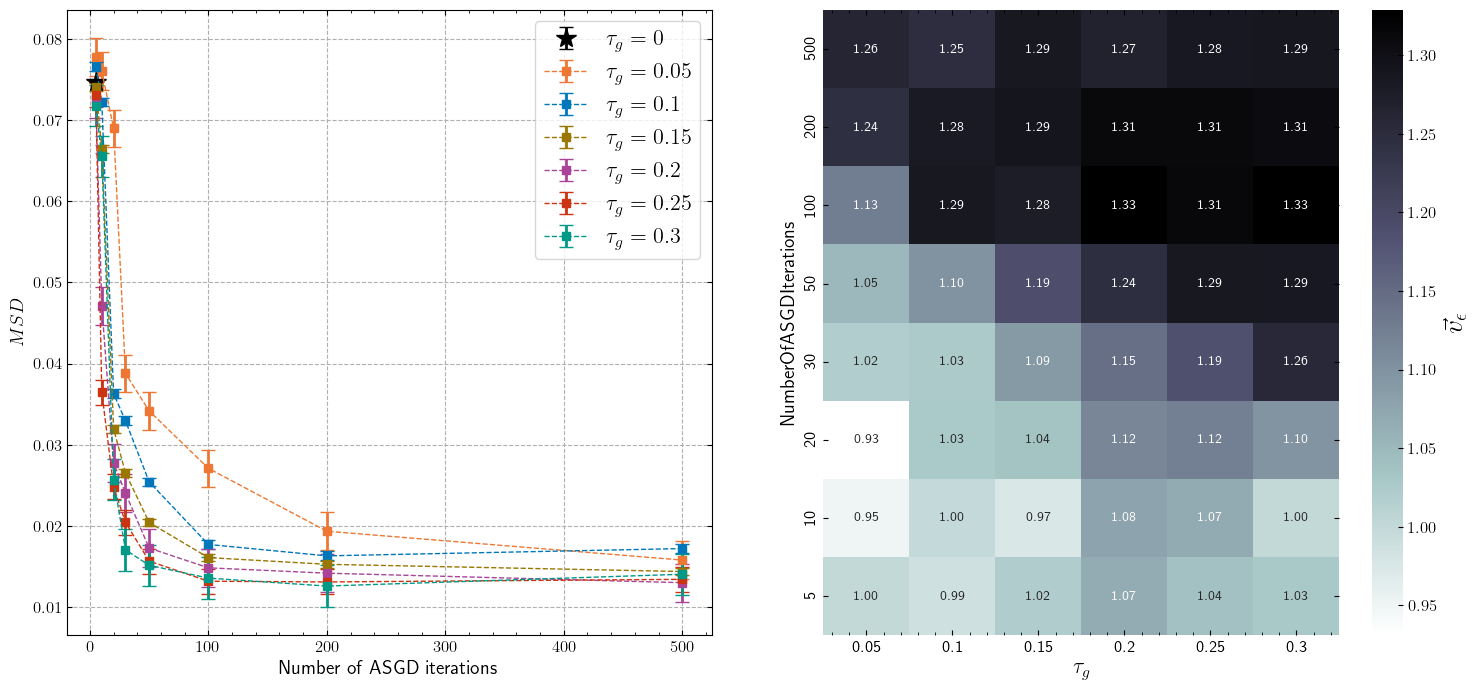

In [7]:
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(15, 7))

for i, df_tau in enumerate(dfs_tau):
    np.random.seed(i+9)
    stds = np.random.uniform(0, 0.003, size=len(dfs_tau[0]))
    if i == 0:
        axes[0].errorbar(df_tau.NumberOfASGDIterations, df_tau["metric"],
        yerr=stds, fmt='*', label=f"$\\tau_g = {taus[i]}$", capsize=5, 
        capthick=1, elinewidth=2, markersize=15, linewidth=1, c="black")
    else:
        axes[0].errorbar(df_tau.NumberOfASGDIterations, df_tau["metric"], 
        yerr=stds, fmt='--s', label=f"$\\tau_g = {taus[i]}$", capsize=5, 
        capthick=1, elinewidth=2, markersize=6, linewidth=1)

df = df.loc[df.TauASGD > 0]
ax = sns.heatmap(df.pivot("NumberOfASGDIterations", "TauASGD", "dvf_rmse"), annot=True, fmt=".2f", cmap="bone_r", ax=axes[1], cbar_kws={'label': '$\\vec{v}_{\\epsilon}$'})
ax.set_xlabel("$\\tau_g$", fontsize=16)
ax.grid(False)
ax.invert_yaxis()
ax.figure.axes[-1].yaxis.label.set_size(20)

axes[0].legend(prop={'size': 16})
axes[0].set_xlabel("Number of ASGD iterations")
axes[0].set_ylabel("$MSD$")

plt.tight_layout(w_pad=5.0)
plt.savefig("hybrid_sweep.pdf")

In [8]:
dfs_tau[0]

,metric,dvf_rmse,NumberOfASGDIterations,TauASGD
0,0.074708,1.01866,5,0.0


In [ ]:
from thesispy.experiments.validation import calc_validation

baseline_runs = []
mesh_sizes = [(3, 3, 3), (4, 4, 4), (5, 5, 5)]

for mesh_size in mesh_sizes:
    runs = get_runs("synthetic_1_fair_comparison", {"config.MeshSize": mesh_size, "config.Optimizer": "GOMEA"})
    baseline_runs.append(runs)

baseline_rmses = []
baseline_tres = []
baseline_bes = []

def get_val_value(val_results, key):
    for val_result in val_results:
        if key in val_result:
            return val_result[key]
    print(f"{key} not found")
    return None

for runs in baseline_runs:
    rmses = []
    tres = []
    bes = []
    for run in runs:
        res = get_run_result("synthetic_1_fair_comparison", run.id)
        val_results = calc_validation(res)
        rmses.append(get_val_value(val_results, "validation/dvf_rmse"))
        tres.append(get_val_value(val_results, "validation/tre"))
        bes.append(get_val_value(val_results, "validation/bending_energy"))
  
    baseline_rmses.append(rmses)
    baseline_tres.append(tres)
    baseline_bes.append(bes)

In [16]:
baseline_rmses = np.loadtxt("baseline_rmses.csv", delimiter=",")
baseline_tres = np.loadtxt("baseline_tres.csv", delimiter=",")
baseline_bes = np.loadtxt("baseline_bes.csv", delimiter=",")

metrics = [baseline_rmses, baseline_tres, baseline_bes]

In [3]:
ds_comparison = get_runs_as_dataset("synthetic_1_fair_comparison_hybrid")
ds_comparison.save()

In [3]:
df_comparison = ds_comparison.aggregate(["MeshSize", "Optimizer"], ["dvf_rmse", "tre", "bending_energy"])
df_comparison = df_comparison.loc[df_comparison.Optimizer == "GOMEA"]
df_comparison = df_comparison.astype({"MeshSize": str})

In [30]:
from scipy.stats import ttest_ind

mesh_sizes = [(3, 3, 3), (4, 4, 4), (5, 5, 5)]
for i, mesh_size in enumerate(mesh_sizes):
    print(f"Mesh size: {mesh_size}")
    baseline_str = ""
    hybrid_str = ""
    for j, metric in enumerate(["dvf_rmse", "tre", "bending_energy"]):
        print(f"  Metric: {metric}")
        hybrid_values = df_comparison.loc[df_comparison.MeshSize == str(mesh_size)][metric].values
        p_value = ttest_ind(metrics[j][i], hybrid_values).pvalue

        print(f"    Baseline: ${metrics[j][i].mean():.2f} \pm {metrics[j][i].std():.2f}$")
        print(f"    Hybrid: $\\textbf{{{hybrid_values.mean():.2f} \pm {hybrid_values.std():.2f}}}$")
        print(f"    P-value: {p_value:.2f}")

        baseline_str += f"${metrics[j][i].mean():.2f} \pm {metrics[j][i].std():.2f}$ & "
        hybrid_str += f"$\\textbf{{{hybrid_values.mean():.2f} \pm {hybrid_values.std():.2f}}}$ & "
    print(baseline_str)
    print(hybrid_str)

Mesh size: (3, 3, 3)
  Metric: dvf_rmse
    Baseline: $0.34 \pm 0.05$
    Hybrid: $\textbf{0.19 \pm 0.01}$
    P-value: 0.00
  Metric: tre
    Baseline: $0.73 \pm 0.10$
    Hybrid: $\textbf{0.51 \pm 0.02}$
    P-value: 0.00
  Metric: bending_energy
    Baseline: $0.08 \pm 0.01$
    Hybrid: $\textbf{0.06 \pm 0.00}$
    P-value: 0.00
$0.34 \pm 0.05$ & $0.73 \pm 0.10$ & $0.08 \pm 0.01$ & 
$\textbf{0.19 \pm 0.01}$ & $\textbf{0.51 \pm 0.02}$ & $\textbf{0.06 \pm 0.00}$ & 
Mesh size: (4, 4, 4)
  Metric: dvf_rmse
    Baseline: $0.85 \pm 0.14$
    Hybrid: $\textbf{0.31 \pm 0.12}$
    P-value: 0.00
  Metric: tre
    Baseline: $2.10 \pm 0.27$
    Hybrid: $\textbf{0.67 \pm 0.29}$
    P-value: 0.00
  Metric: bending_energy
    Baseline: $0.62 \pm 0.17$
    Hybrid: $\textbf{0.08 \pm 0.02}$
    P-value: 0.00
$0.85 \pm 0.14$ & $2.10 \pm 0.27$ & $0.62 \pm 0.17$ & 
$\textbf{0.31 \pm 0.12}$ & $\textbf{0.67 \pm 0.29}$ & $\textbf{0.08 \pm 0.02}$ & 
Mesh size: (5, 5, 5)
  Metric: dvf_rmse
    Baseline: $0.8

In [2]:
from thesispy.experiments.validation import jacobian_determinant, plot_run_result, get_vmin_vmax

hybrid_run = get_run_result("synthetic_1_fair_comparison_hybrid", "2tvp3wy2")
baseline_run = get_run_result("synthetic_1_fair_comparison", "ccwwhrm7")

clim_dvf, clim_jac = get_vmin_vmax(baseline_run, hybrid_run)

2023-01-18 11:16:33,980 - Validation - INFO - Jacobian min,max: 0.03612946312935543, 7.151605943304132
2023-01-18 11:16:33,984 - Validation - INFO - Jacobian min,max: 0.2134953197115728, 6.892683679514449


2023-01-18 11:17:35,408 - Validation - INFO - Jacobian min,max: 0.2134953197115728, 6.892683679514449


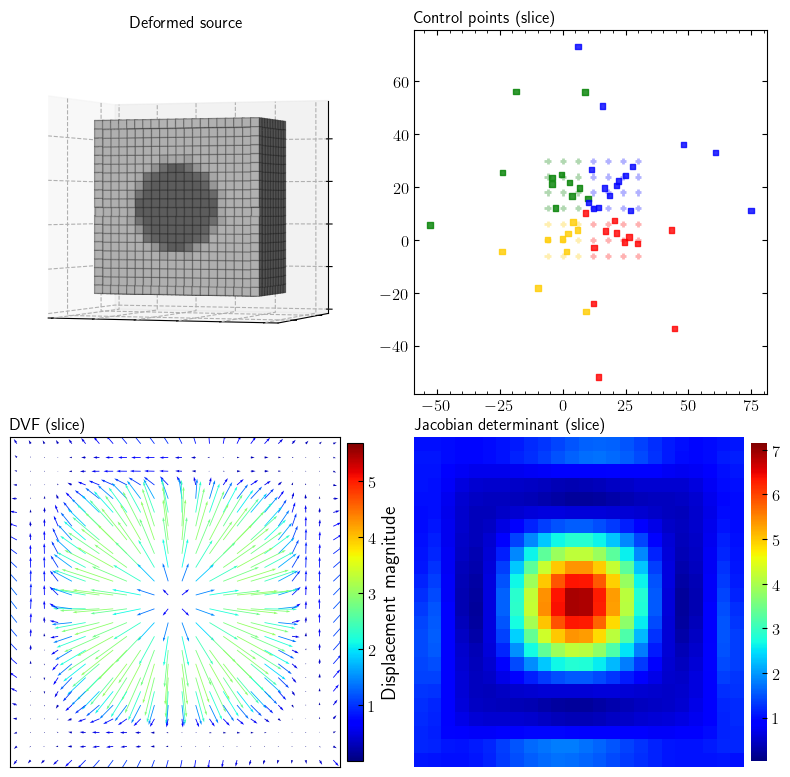

In [5]:
from thesispy.experiments.validation import plot_run_result

plot_run_result(hybrid_run, clim_dvf=clim_dvf, clim_jac=clim_jac)
plt.savefig("hybrid_run.pdf")

2023-01-18 11:17:42,971 - Validation - INFO - Jacobian min,max: 0.03612946312935543, 7.151605943304132


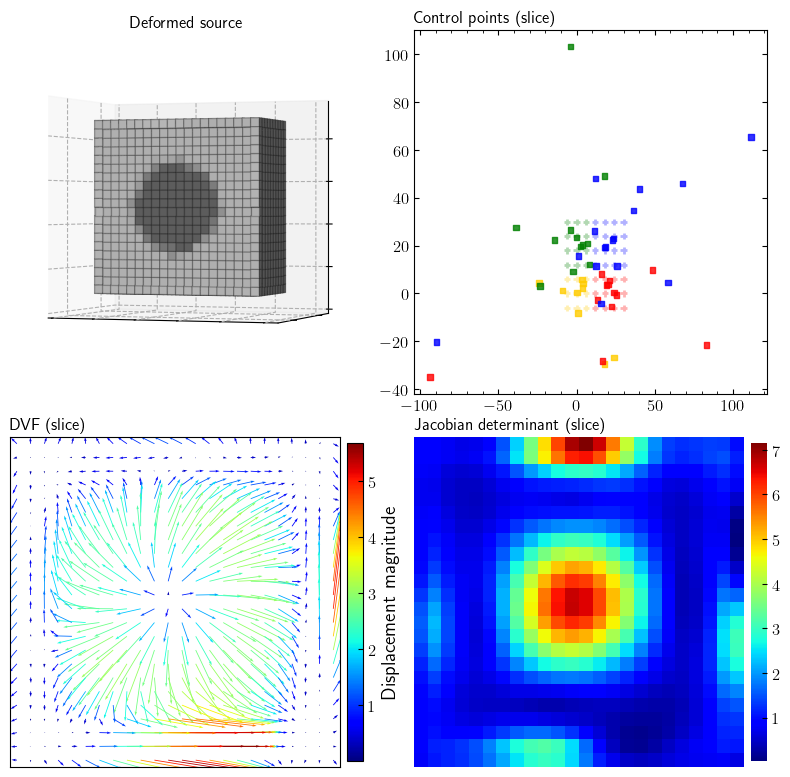

In [6]:
plot_run_result(baseline_run, clim_dvf=clim_dvf, clim_jac=clim_jac)
plt.savefig("baseline_run.pdf")

In [11]:
ds_baseline = get_runs_as_dataset("synthetic_1_fair_comparison")
for run in ds_baseline.runs:
    if "2a:metric" in run.resolutions[0].columns:
        run.resolutions[0].rename(columns={"2a:metric": "metric"}, inplace=True)
        run.summary.rename({"2a:metric": "metric"}, inplace=True)

ds_baseline.save()

ds_baseline = ds_baseline.filter("Optimizer == 'GOMEA'")
arrs_baseline = ds_baseline.aggregate_for_plot(["MeshSize"])
times_baseline = ds_baseline.aggregate(["MeshSize"], ["time[ms]"], val=False)

ds_hybrid = get_runs_as_dataset("synthetic_1_fair_comparison_hybrid")
ds_asgd, ds_hybrid = ds_hybrid.filter("Optimizer == 'AdaptiveStochasticGradientDescent'"), ds_hybrid.filter("Optimizer == 'GOMEA'")
arrs_hybrid = ds_hybrid.aggregate_for_plot(["MeshSize"])
arrs_asgd = ds_asgd.aggregate_for_plot(["MeshSize"])
times_hybrid = ds_hybrid.aggregate(["MeshSize"], ["time[ms]"], val=False)
times_asgd = ds_asgd.aggregate(["MeshSize"], ["time[ms]"], val=False)

arrs = {
    "GOMEA": arrs_baseline,
    "GOMEA-LS": arrs_hybrid,
    "ASGD": arrs_asgd
}

In [12]:
median_times_baseline = []
median_times_hybrid = []
median_times_asgd = []
mesh_sizes = [(3, 3, 3), (4, 4, 4), (5, 5, 5)]

for i, mesh_size in enumerate(mesh_sizes):
    df_baseline = times_baseline.loc[times_baseline.MeshSize == str(mesh_size)]
    df_hybrid = times_hybrid.loc[times_hybrid.MeshSize == str(mesh_size)]
    df_asgd = times_asgd.loc[times_asgd.MeshSize == str(mesh_size)]
    median_times_baseline.append(df_baseline["time[ms]"].median())
    median_times_hybrid.append(df_hybrid["time[ms]"].median())
    median_times_asgd.append(df_asgd["time[ms]"].median())

median_times = {
    "GOMEA": median_times_baseline,
    "GOMEA-LS": median_times_hybrid,
    "ASGD": median_times_asgd
}

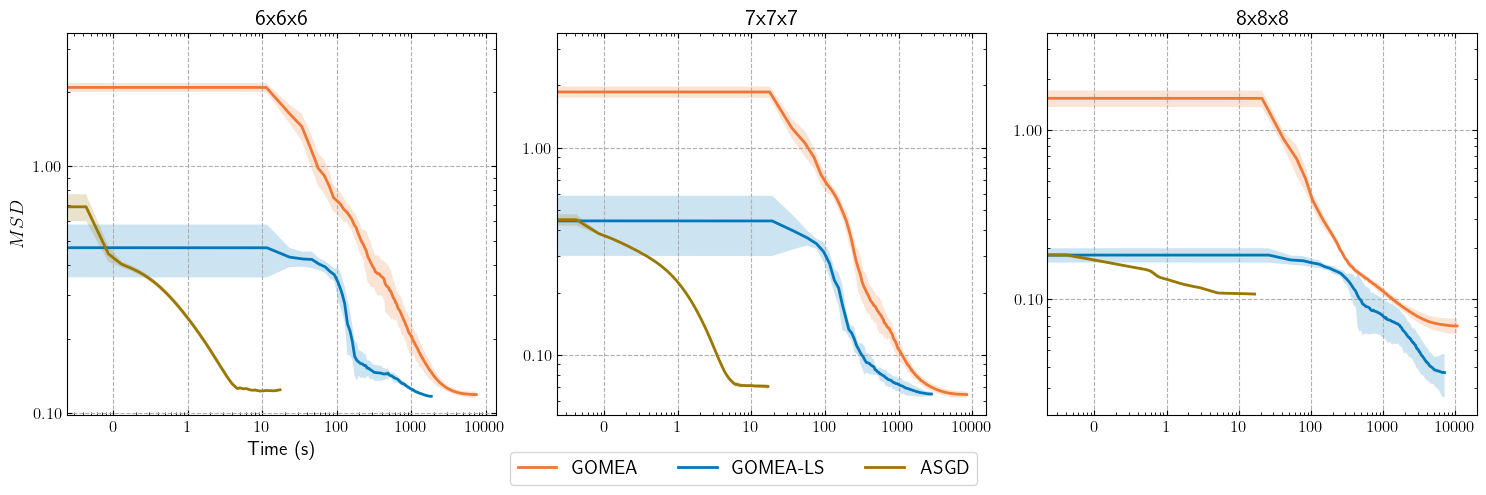

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
formatter = ScalarFormatter(useMathText=True)
formatter.set_scientific(False)

for optimizer in ["GOMEA", "GOMEA-LS", "ASGD"]:
    for i, mesh_size in enumerate(mesh_sizes):
        arr_avg, arr_median, arr_std = arrs[optimizer][(mesh_size,)]
        xs = [median_times[optimizer][i] * j / 1000 for j in range(len(arr_avg))]
        axes[i].plot(xs, arr_avg, label=optimizer)
        axes[i].fill_between(xs, arr_avg - arr_std, arr_avg + arr_std, alpha=0.2)
        
        # formatting
        axes[i].set_yscale("log")
        axes[i].set_xscale("log")
        axes[i].yaxis.set_major_formatter(formatter)
        axes[i].xaxis.set_major_formatter(formatter)
        axes[i].set_title(mesh_size_as_str(mesh_size), loc="center")


axes[0].set_xlabel("Time (s)")
axes[0].set_ylabel("$MSD$")
handles, labels = axes[2].get_legend_handles_labels()
fig.legend(handles, labels, ncol=3, loc="lower center", prop={'size': 14})

plt.tight_layout(rect=[0, 0.04, 1, 1])
plt.savefig("performance.pdf")